# HHL 算法

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/mindquantum/zh_cn/mindspore_hhl_algorithm.ipynb)
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/mindquantum/zh_cn/mindspore_hhl_algorithm.py)
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.2/docs/mindquantum/docs/source_zh_cn/hhl_algorithm.ipynb)

## 概述

**HHL算法的目的：** 给定一个 Hermitian $A$ 和一个单位向量 $\vec{b}$，
求解方程 $A \vec{x} = \vec{b}$ 。

令 $\left| b  \right\rangle = \sum_{j=1}^{N} b_{j } \left| j   \right\rangle$，
算法的关键在于在 $\left|b \right\rangle$ 上模拟 $e^{i A \Delta t }$ 。

设 $A$ 的谱分解如下

$$A = \sum_{j=1}^{N} \lambda_{j } \left| u_{j} \right\rangle \left\langle u_{j} \right|$$

那么

$$e^{i A \Delta t } = \sum_{j=1}^{N} e^{i \lambda_{j} \Delta t } \left| u_{j} \right\rangle \left\langle u_{j} \right|$$

将 $\left| b  \right\rangle$ 用基 $\left\lbrace \left| u_{j} \right\rangle \right\rbrace$ 表示 ： $\left| b  \right\rangle = \sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle$ 。

使用量子相位估计 QPE（Quantum Phase Estimation），其中 $U = e^{i A \Delta t}$，作用结果如下：

$$\left| b  \right\rangle \xrightarrow{\text{QPE}} \sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle | \widetilde{ \lambda_j } \rangle$$

其中 $| \widetilde{\lambda_j} \rangle$ 是特征值 $\lambda_{j}$ 的估计（波浪线表示估计值，下文同理）。

很容易看出方程的解就是

$$
\left| x  \right\rangle = A^{-1 } \left| b  \right\rangle = \sum_{j}^{ } \beta_{j } (\lambda_{j})^{-1 } \left| u_{j} \right\rangle
$$

所以我们只需要将信息从量子态 $| \widetilde{\lambda_j} \rangle$ 中提取出来即可。

## HHL 算法步骤

下面详细介绍 HHL 算法的详细步骤，包含详细的数学推导。

### 数据预处理

前面提到 $A$ 需要是 Hermitian 的，也就是 $A^\dagger = A$。其实这个条件可以放宽，如果 $A$ 不是 Hermitian 的，构造 $\tilde{A}$ 如下：

$$
\tilde{A} = \begin{pmatrix}
0 & A \\
A^{\dagger } & 0 \\
\end{pmatrix}
$$

然后求解方程

$$
\tilde{A} \vec{y} = \begin{pmatrix}
\vec{b} \\
0 \\
\end{pmatrix}
$$

很容易验证方程的解 $\vec{y}$ 一定具有如下的形式

$$
\vec{y} = \begin{pmatrix}
0 \\
\vec{x} \\
\end{pmatrix}
$$

其中 $A \vec{x} = \vec{b}$ 。

对于 $\vec{b}$，因为 HHL 是量子算法，所以需要输入的是量子态 $|b\rangle = \sum_{j=1}^N b_j |j\rangle$ 。关于如何制备这样量子态，如何将经典信息编码到量子信息，不是本算法关心的重点，这里只假设制备好了这样的量子态。

### 制备算子 $U = e^{i A \Delta t}$

如何高效的制备算子 $U = e^{i A \Delta t}$ 是核心问题。后面将会看到，整个 HHL 算法的复杂度主要取决于算子 $U$ ，所以需要高效的模拟 $U$ 。

制备这个时间演化算子 $U = e^{i A \Delta t}$ 属于量子系统模拟（哈密顿量模拟）问题，本身是一个重要的量子问题，这里并不展开讨论。

在原论文中，对矩阵 $A$ 作出了**稀疏性**的限制，其目的就是能够高效的模拟 $e^{i A \Delta t}$。对于一般的稠密矩阵 $A$，模拟其演化复杂度可能很高。

这里不去展开证明 QPE 的正确性，读者只需要知道 QPE 的输入是一个酉算子 $U$ 和其特征向量 $|u\rangle$，设 $U |u\rangle = e^{2 \pi i \varphi} |u\rangle$ ，输出是 $\varphi$ 的估计 $\tilde{\varphi}$ 。

具体来说，使用 $t$ 个辅助量子比特, QPE 的作用如下

$$\left| b  \right\rangle \left| 0 \right\rangle^{\otimes t} \left| 0 \right\rangle = \sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle \left| 0 \right\rangle^{\otimes t} \left| 0 \right\rangle
\xrightarrow{\text{QPE}} \sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle \left| \widetilde{\varphi_j} \right\rangle \left| 0 \right\rangle$$

其中 $\left| \widetilde{\varphi_j} \right\rangle$ 是相位 $\varphi_{j}$ 的估计。
这里在 $t$ 个辅助比特后面还增加了一个辅助比特，是用于后面的旋转步骤。

为了更好的理解，这里举一个例子：
取

$$A = Z = \left| 0 \right\rangle \left\langle 0 \right| - \left| 1 \right\rangle \left\langle 1 \right|$$

那么

$$U = e^{i A \Delta t } = e^{i \Delta t} \left| 0 \right\rangle \left\langle 0 \right| + e^{-i \Delta t} \left| 1 \right\rangle \left\langle 1 \right|$$

两个相位分别是 $\varphi_{1} = \Delta t / 2 \pi$ 和 $\varphi_{2} = -\Delta t / 2 \pi$ 。

如果我们使用 $t = 4$ 个辅助比特，并且取 $\Delta t = \pi / 4$，那么 $\varphi_{1} = 1 / 8$ 和 $\varphi_{2} = - 1 / 8$ 。

两个相位的估计值分别是 $\widetilde{\varphi_1} = 0.0010 \times 2^4 = 2$ 和 $\widetilde{\varphi_2} = 0.1110 \times 2^4 = 14$ 。
因为相位是 $[0, 1)$ 之间的小数 $0.q_{t_1}q_{t_2}\ldots q_{t_t}$，
乘上 $2^t$ 得到其对应的量子态 $|q_{t_1} \ldots q_{t_t} \rangle$ 。
需要指出的是，因为相位是模 $1$ 的小数，$-0.0010$ 被映射到了 $0.1110$，我们想要还原相位（为了还原 $\lambda$），首先通过选取足够小的 $\Delta t$ 使得 $|\varphi| < 1 / 2$，这样如果 $|q_{t_1} \ldots q_{t_t}\rangle < 2^{t-1}$ 对应正数，$|q_{t_1}\ldots q_{t_t}\rangle > 2^{t-1}$ 对应负数。

通过简单的定量计算，我们得到如下的映射关系：

$$
\frac{\lambda \Delta t}{2 \pi} =   \varphi = \begin{cases}
\tilde{\varphi} / 2^{t} &  , \varphi > 0 & , \tilde{\varphi} < 2^{t-1} \\
\tilde{\varphi} / 2^{t} - 1 & , \varphi < 0 & , \tilde{\varphi} > 2^{t-1}\\
\end{cases}
$$

其中 $\lambda$ 是 $A$ 的特征值，$\varphi$ 是 $U = e^{i A \Delta t}$ 的相位，$\tilde{\varphi}$ 是 $\varphi$ 的估计。

### 条件旋转

经过 QPE 后，整个量子态如下

$$
\sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle \left| \widetilde{\varphi_j} \right\rangle \left| 0 \right\rangle
$$

想要将 $\lambda_j$ 的信息从量子态 $\left| \widetilde{\varphi_j} \right\rangle$ 中提取出来， 我们需要使用条件旋转门 $CR(k)$， 其作用效果如下

$$
CR(k) \left| \tilde{\varphi} \right\rangle \left| b \right\rangle = \begin{cases}
\left| \tilde{\varphi} \right\rangle \left| b \right\rangle & ,  k \neq \tilde{\varphi}  \\
\left| \tilde{\varphi} \right\rangle R_y \left( 2 \arcsin \frac{C}{\lambda} \right) \left| b \right\rangle & , k = \tilde{\varphi} \\
\end{cases}
$$

简单来说，只有当 $k$ 选择了正确的 $\tilde{\varphi}$，才会对后面的量子比特作用旋转操作。

因为我们不知道正确的 $\tilde{\varphi}$ 是什么，所以暴力的枚举所有的可能 $CR(k)$， $k = 1, \ldots , 2^{t}-1$ 。

旋转的效果是很简单的

$$
\prod_{k=1}^{2^{t} - 1} I\otimes CR(k) \sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle \left| \widetilde{\varphi_j} \right\rangle \left| 0 \right\rangle
= \sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle \left| \widetilde{\varphi_j} \right\rangle \left( \sqrt{1 - \left( \frac{C}{\lambda_{j}} \right)^{2}} \left| 0 \right\rangle + \frac{C}{\lambda_{j}} \left| 1 \right\rangle \right)
$$

再作用一次逆 QPE，整体的量子态如下

$$
\left| \psi \right\rangle = \sum_{j=1}^{N} \beta_{j} \left| u_{j} \right\rangle \left| 0 \right\rangle^{\otimes t} \left( \sqrt{1 - \left( \frac{C}{\lambda_{j}} \right)^{2}} \left| 0 \right\rangle + \frac{C}{\lambda_{j}} \left| 1 \right\rangle \right)
$$

### 测量

对最后一个量子比特进行测量， 当测量结果是 $\left| 1 \right\rangle$ 时， 其概率是

$$
p_1 = C^{2} \sum_{j=1}^{N} ( \beta_{j} / \lambda_{j} )^{2}
$$

测量后的量子态变为

$$
\left| \psi_{1} \right\rangle = \frac{1}{\left( \sum_{j=1}^{N} \left( \beta_{j} / \lambda_{j} \right)^{2} \right)^{-1}} \sum_{j=1}^{N} \frac{\beta_{j}}{\lambda_{j}} \left| u_{j} \right\rangle \left| 0 \right\rangle^{\otimes t} \left| 1 \right\rangle
$$

显然此时三个量子寄存器之间不存在纠缠，如果只看第一个量子寄存器，它已经是 $|x\rangle$ 的状态了（忽略掉一个归一化系数）。

需要指出的是，旋转操作里面有一个参数 $C$， 我们看到 $C$ 不会影响最后结果的正确性， 但是却实实在在的影响了得到结果的概率 $p_{1}$ 。
我们肯定希望 $C$ 能够尽可能大，从而使 $p_1$ 尽可能大。但是 $C \leq \left\vert \lambda_{j} \right\vert$ ，它要比所有特征值的绝对值还要小，如果没有先验信息，不知道绝对值最小的 $\lambda$ 有多大，那么就只能保守的取一个很小的 $C$，然后可以通过振幅放大技术来增大得到结果的概率。

## MindQuantum 实现

这里使用 MindQuantum 实现一个简单的例子，仅说明 HHL 算法的过程和正确性。

为了计算方便，我们选取一个简单的
$A = Z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}$，因为其时间演化算子 $e^{i Z \Delta t} = R_z(- 2 \Delta t)$ ，比较容易实现。

In [1]:
import numpy as np

A = np.array([[1, 0], [0, -1]])
es, vs = np.linalg.eig(A)

print(f"eigenvalues of A:\n {es}")
print(f"eigenvectors of A:\n {vs}")

b = np.array([0.6, 0.8])
print(f"b: {b}")
print(f"Solution of Ax=b is: {np.linalg.solve(A, b)}")

eigenvalues of A:
 [ 1. -1.]
eigenvectors of A:
 [[1. 0.]
 [0. 1.]]
b: [0.6 0.8]
Solution of Ax=b is: [ 0.6 -0.8]


这里导入所需要的各种函数：

In [2]:
from mindquantum.core.gates import H, X, RY, RZ, Measure, Power, BARRIER
from mindquantum.core.circuit import Circuit
from mindquantum.simulator import Simulator

对于量子态 $|b\rangle = \cos\theta |0\rangle + \sin\theta |1\rangle$ 的制备，可以通过一个 $R_y(2 \theta)$ 实现。

下面的代码制备了 $|b\rangle = 0.6 |0\rangle + 0.8 |1\rangle$ 并进行了测量。

In [3]:
circ = Circuit()
circ += RY(2 * np.arcsin(0.8)).on(0)
circ += Measure().on(0)

sim = Simulator(backend="mqvector", n_qubits=1)
sim.sampling(circ, shots=10000)

shots: 10000
Keys: q0│0.00    0.16        0.32       0.481       0.641       0.801
────────┼───────────┴───────────┴───────────┴───────────┴───────────┴
       0│▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
        │
       1│▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
        │
{'0': 3593, '1': 6407}

下面一步步构建出完整的量子线路，取 $t = 4$，$\Delta t = \pi / 4$， $C = 0.5$。

- 首先是 QPE
- 然后是 $CR(k)$，$k = 1, \ldots, 15$
- 接着是 逆QPE
- 最后测量

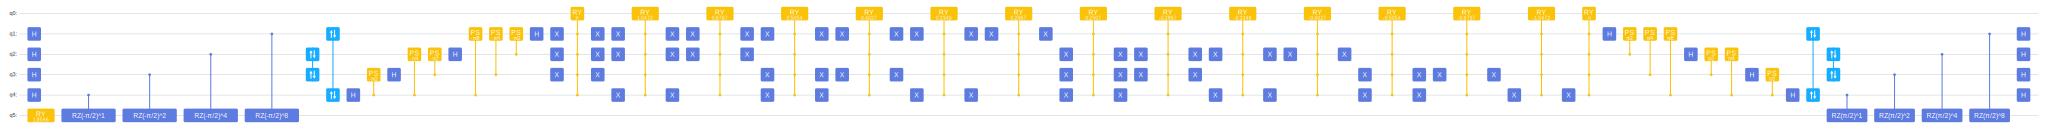

In [4]:
from mindquantum.algorithm.library import qft

# q1 ~ q4 : for QPE
t = 4
qc = [4, 3, 2, 1]

# store |b> , and store the result |x>
qb = 5

# use for conditional rotation
qs = 0

# choose a time evolution
dt = np.pi / 4

# choose a small C
C = 0.5

circ = Circuit()

# prepare b
circ += RY(2 * np.arcsin(0.8)).on(qb)

# QPE
for i in qc:
    circ += H.on(i)

for (i, q) in enumerate(qc):
    circ += Power(RZ(-2 * dt), 2**i).on(qb, q)

# apply inverse QFT
circ += qft(list(reversed(qc))).hermitian()

# conditional rotate
circ += BARRIER
for k in range(1, 2**t):
    for i in range(t):
        if (k & (1 << i)) == 0:
            circ += X.on(qc[i])
    phi = k / (2**t)
    if k > 2**(t-1):
        phi -= 1.0
    l = 2 * np.pi / dt * phi
    circ += RY(2 * np.arcsin(C / l)).on(qs, qc)

    for i in range(t):
        if (k & (1 << i)) == 0:
            circ += X.on(qc[i])
    circ += BARRIER

# apply inverse QPE
circ += qft(list(reversed(qc)))

for (i, q) in enumerate(qc):
    circ += Power(RZ(2 * dt), 2**i).on(qb, q)

for i in qc:
    circ += H.on(i)

circ.svg()

如何验证我们的结果的正确性？测量。因为结果是量子态 $|x\rangle$，目前 MindQuantum 没有相关的办法能够单独取出某一个量子比特的内部值，我们只能通过测量。

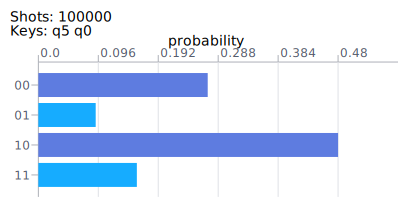

In [5]:
sim = Simulator(backend="mqvector", n_qubits=2 + t)
sim.apply_circuit(circ)

circ_m = Circuit()
circ_m += Measure().on(qs)
circ_m += Measure().on(qb)

res = sim.sampling(circ_m, shots=100000)
res.svg()

In [6]:
res.data.get("01", 0) / (res.data.get("01", 0) + res.data.get("11", 0))

0.36792717648474155

通过统计当 `q0` 是 1 时，`q5` 的测量结果，我们看到 `q5 = 0` 的占比是 `0.36`，和答案的预期一致。

当然这种方法只能得到振幅大小，想要得到更多信息，例如相位，需要对测量进行调整，这里不去讨论。

In [7]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')